# Figures 3, 4, & 5: WASP-69 with tellurics joint modeling

[WASP-69](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-69) makes a great demo because it has a very low $v\sin{i}$ of 2.2 km/s, which means that its spectral lines appear exceptionally sharp.  Here we will analyze a single (noisy) spectrum of WASP-69 observed with HPF.  


**Warning** This demo is a work in progress as of June 13, 2022. Check back in soon for the final (regularized) fit.  

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cuda'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum

In [5]:
raw_data = HPFSpectrum(file='../../data/HPF/WASP-69/Goldilocks_20191019T015252_v1.0_0002.spectra.fits', order=2)

In [6]:
data = raw_data.sky_subtract().trim_edges().remove_nans().deblaze().normalize(normalize_by='peak')

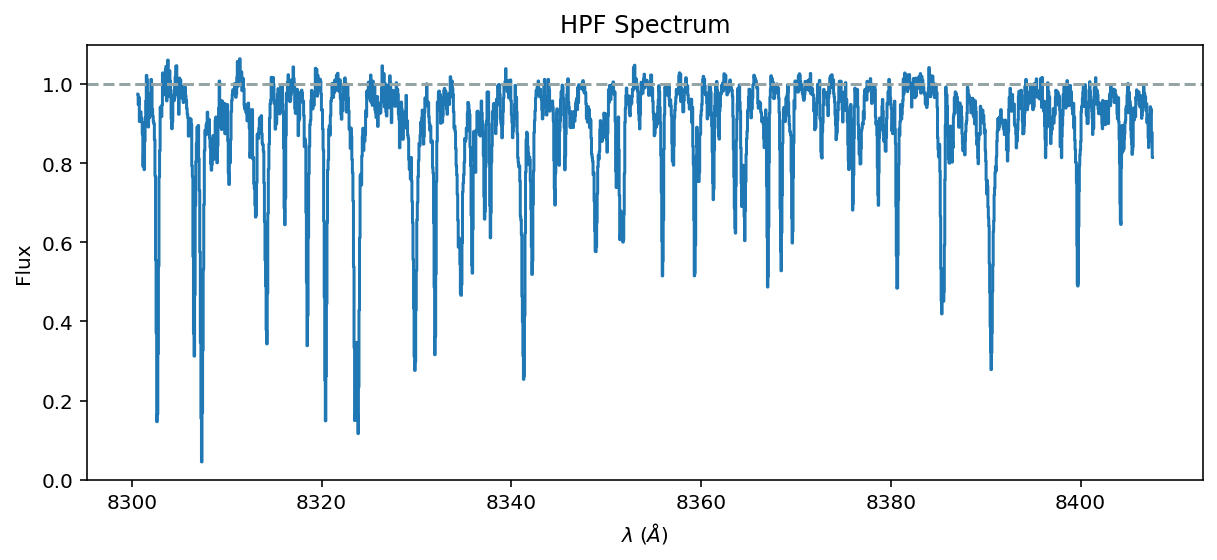

In [7]:
ax = data.plot(yhi=1.1);
ax.axhline(1.0, color='#95a5a6', linestyle='dashed');

In [8]:
wl_lo = 8300-30.0
wl_hi = 8420+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

WASP-69 has $T_{\mathrm{eff}}=4700\;K$ and $\log{g}=4.5$, according to sources obtained through NASA Exoplanet Archive (Bonomo et al. 2017, Stassun et al. 2017, Anderson et al. 2014, and references therein).  Let's start with a PHOENIX model possessing these properties.

In [9]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=wl_lo, wl_hi=wl_hi)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

In [10]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM'] # Fahrenheit and Relative Humidity

(64.38, 39.601)

That's about 290 Kelvin and 40% humidity.

In [11]:
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [12]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

## Initial guess

In [13]:
BERV = data.estimate_barycorr().to(u.km/u.s).value

In [14]:
system_RV = -9.5 #km/s
BERV = data.estimate_barycorr().to(u.km/u.s).value
observed_RV = system_RV - BERV#km/s
vsini = 2.2 #km/s
resolving_power = 55_000
initial_guess = spectrum.resample_to_uniform_in_velocity()\
                        .rv_shift(observed_RV)\
                        .rotationally_broaden(vsini)\
                        .instrumental_broaden(resolving_power)\
                        .resample(data)

initial_telluric = telluric_spectrum.instrumental_broaden(resolving_power)\
                                         .resample(data)

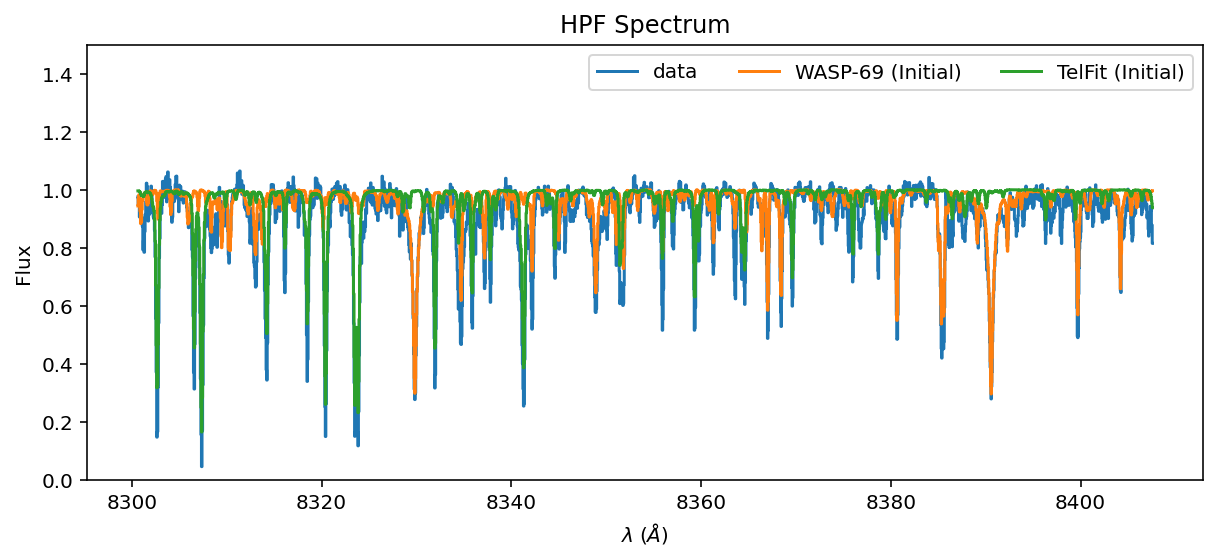

In [15]:
ax = data.plot(label='data')
initial_guess.plot(ax=ax, label='WASP-69 (Initial)')
initial_telluric.plot(ax=ax, label='TelFit (Initial)')
ax.legend(ncol=3);

Ok, the lines are in the right place, but the amplitudes are inexact.  Let's tune them with `blase`!

### Clone the stellar and telluric model

In [16]:
stellar_emulator = SparseLogEmulator(spectrum.wavelength.value, 
                                     np.log(spectrum.flux.value), prominence=0.01, device=device)
stellar_emulator.to(device)

/home/gully/GitHub/blase/src/blase/emulator.py:360: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 290 spectral lines


SparseLogEmulator()

In [17]:
telluric_emulator = SparseLogEmulator(telluric_spectrum.wavelength.value, 
                                      np.log(telluric_spectrum.flux.value), 
                                      prominence=0.01, device=device)
telluric_emulator.to(device)

Initializing a sparse model with 148 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [18]:
stellar_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00010683: 100%|███████████| 1000/1000 [00:04<00:00, 203.65it/s]


In [19]:
telluric_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00000873: 100%|███████████| 1000/1000 [00:04<00:00, 210.40it/s]


### Step 3: Extrinsic model

In [20]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [21]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=telluric_emulator.state_dict(), device=device)
telluric_emulator.to(device)

Initializing a sparse model with 290 spectral lines
Initializing a sparse model with 148 spectral lines


SparseLogEmulator()

#### Forward model

In [22]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

#### Joint telluric and stellar model

In [23]:
flux_at_telescope = broadened_flux * telluric_attenuation

#### Instrumental model

In [24]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=15, out_features=1, bias=True)
)

In [25]:
8330/(2.344*0.064)

55527.41040955632

In [26]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [27]:
detector_flux = instrumental_model.forward(flux_at_telescope)

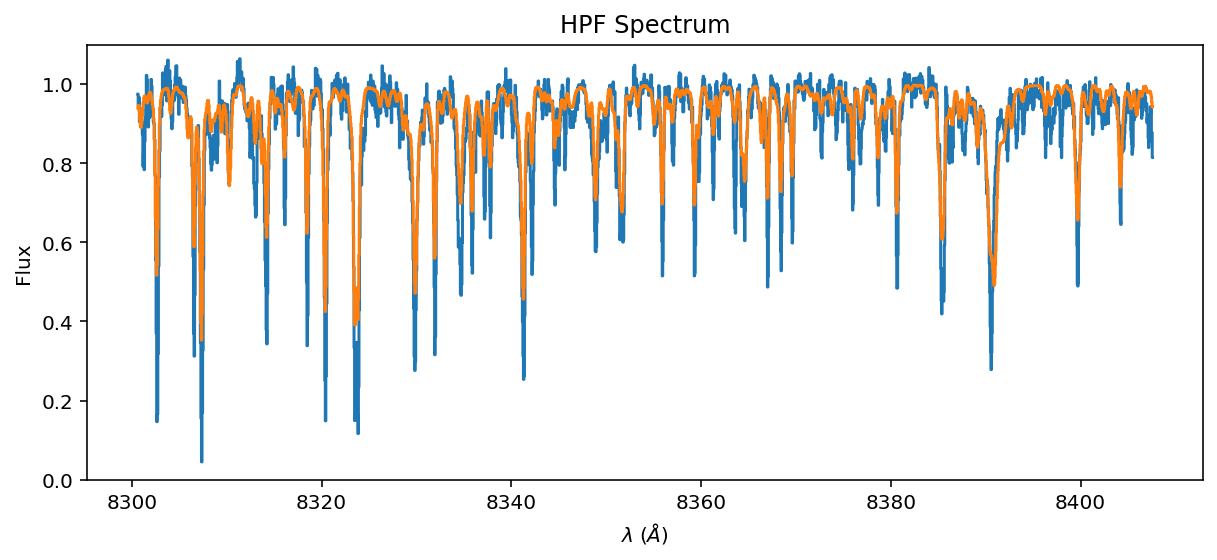

In [28]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
#ax.set_xlim(8320, 8340)

## Transfer learn a semi-empirical model (work in progress!)

June 13, 2022--- This is a work in progress!! We are fine-tuning the regularization.  The code works, but overfits (as expected, for reasons discussed in the paper draft).  We want tune the regularization hyper parameters for this demo.  That's the next step! Stay tuned...

In [29]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [30]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [31]:
loss_fn = nn.MSELoss(reduction="mean")

In [32]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, telluric_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters()))
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())),
    0.01,
    amsgrad=True,
)         

In [33]:
n_epochs = 1000
losses = []

### (TODO) Implement the regularization...

For all fine-tuned parameters...

In [35]:
#with torch.no_grad():
#    amplitude_init = copy.deepcopy(torch.exp(stellar_emulator.amplitudes))

# Define the prior on the amplitude
def ln_prior(amplitude_vector):
    """
    Prior for the amplitude vector
    """
    amplitude_difference = amplitude_init - torch.exp(amplitude_vector)
    return 0.5 * torch.sum((amplitude_difference ** 2) / (0.01 ** 2))


In [36]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    telluric_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()
    flux_at_telescope = broadened_flux * telluric_attenuation
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux, data_target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 0.00018841: 100%|████████████| 1000/1000 [01:21<00:00, 12.26it/s]


### Spot check the results...

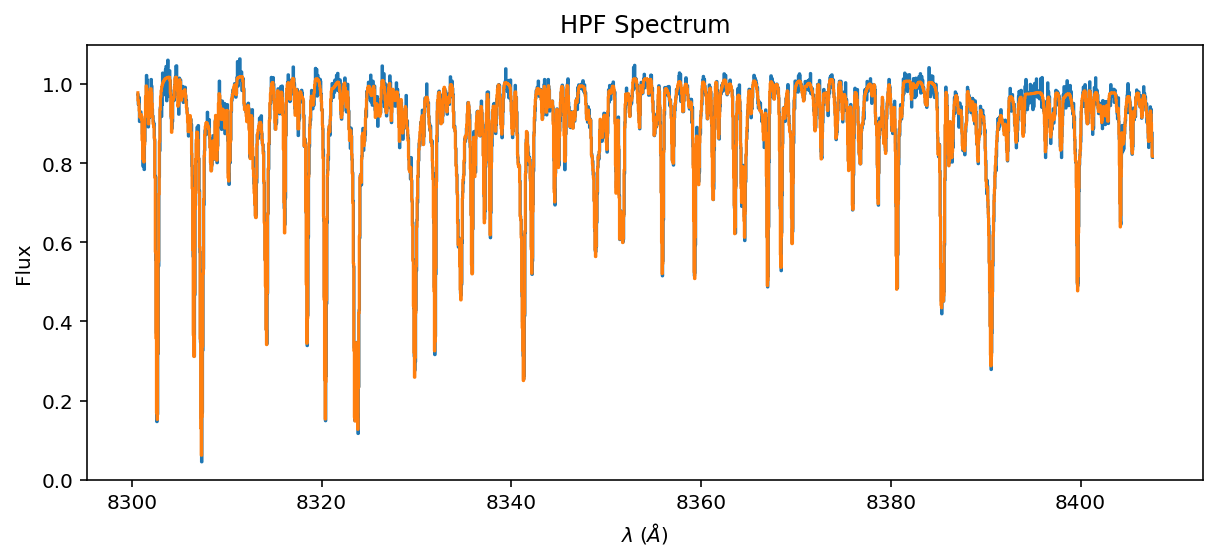

In [39]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());

(8320.0, 8340.0)

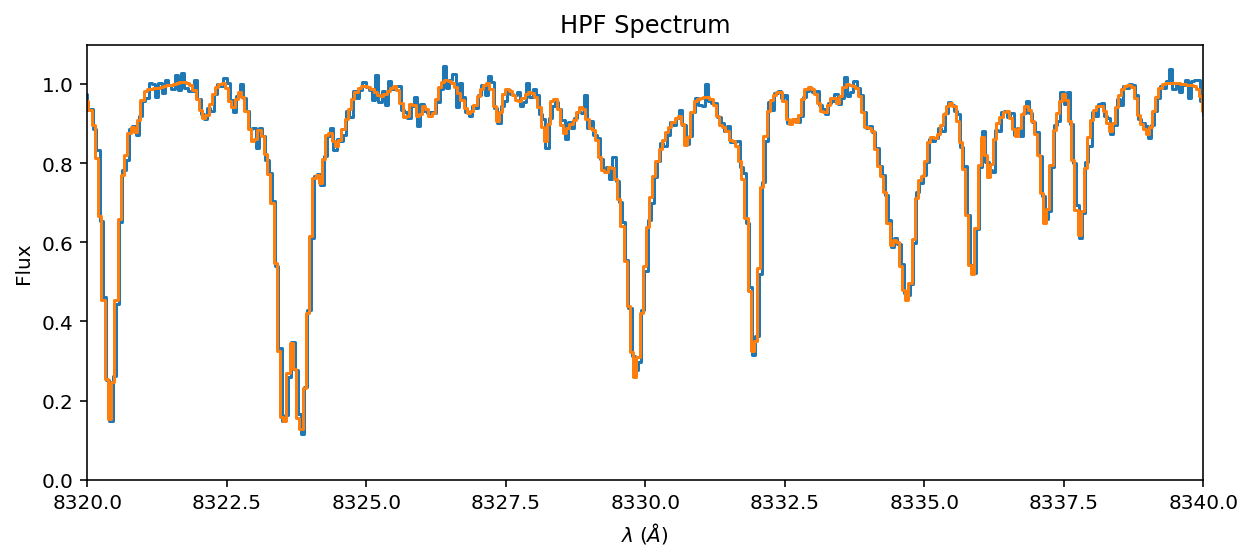

In [38]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(8320, 8340)

Don't get too excited! This performance is **very overfit**.  It needs regularization!

In [40]:
with torch.no_grad():
    print(8330/(2.355*torch.exp(instrumental_model.ln_sigma_angs)))

tensor(144767.7031)


In [41]:
stellar_emulator.radial_velocity

Parameter containing:
tensor(18.0999, device='cuda:0', dtype=torch.float64, requires_grad=True)

In [42]:
with torch.no_grad():
    print(torch.exp(extrinsic_layer.ln_vsini))

tensor(0.8263, device='cuda:0')


To be continued...